<a href="https://colab.research.google.com/github/Patricup/UAS_BDDM_PENGOPTIMALAN-_KONSUMSI_ENERGI/blob/main/22_11_4776_UAS_BDDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IDENTITAS
nama : Patri Retta Siana

Nim : 22.11.4776

#IMPORT LIBRARY

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.optimize import differential_evolution
import gym
from gym import spaces
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler


#PreProcessing Data

In [2]:
data_set_path = kagglehub.dataset_download("arnavsmayan/smart-home-energy-usage-dataset")
print("Path to dataset files:", data_set_path)

data_file = f"{data_set_path}/smart_home_energy_usage_dataset.csv"
data= pd.read_csv(data_file)


Path to dataset files: /root/.cache/kagglehub/datasets/arnavsmayan/smart-home-energy-usage-dataset/versions/1


In [3]:
data.info()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   timestamp               1000000 non-null  object 
 1   home_id                 1000000 non-null  int64  
 2   energy_consumption_kWh  1000000 non-null  float64
 3   temperature_setting_C   1000000 non-null  float64
 4   occupancy_status        1000000 non-null  object 
 5   appliance               1000000 non-null  object 
 6   usage_duration_minutes  1000000 non-null  int64  
 7   season                  1000000 non-null  object 
 8   day_of_week             1000000 non-null  object 
 9   holiday                 1000000 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 76.3+ MB


In [4]:
data.describe()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,home_id,energy_consumption_kWh,temperature_setting_C,usage_duration_minutes,holiday
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,50.019812,2.548839,19.999284,59.505089,0.099588
std,28.605155,1.415527,2.887678,34.651890,0.299450
min,1.000000,0.100000,15.000000,0.000000,0.000000
25%,25.000000,1.320000,17.500000,30.000000,0.000000
50%,50.000000,2.550000,20.000000,59.000000,0.000000
75%,75.000000,3.780000,22.500000,90.000000,0.000000
max,99.000000,5.000000,25.000000,119.000000,1.000000


In [5]:
data.isnull().sum()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
timestamp,0
home_id,0
energy_consumption_kWh,0
temperature_setting_C,0
occupancy_status,0
appliance,0
usage_duration_minutes,0
season,0
day_of_week,0
holiday,0


In [6]:
print("Duplicate Values =",data.duplicated().sum())

Duplicate Values = 0


#Batasi ukuran kumpulan data hingga 10000 sampel untuk mengurangi waktu pelatihan

In [7]:
data = data.sample(n=10000, random_state=42)
data.head()

,timestamp,home_id,energy_consumption_kWh,temperature_setting_C,occupancy_status,appliance,usage_duration_minutes,season,day_of_week,holiday
987231,2135-08-16 15:00:00,48,1.40,16.9,Unoccupied,Electronics,58,Autumn,Tuesday,0
79954,2032-02-14 10:00:00,65,1.23,21.1,Unoccupied,Dishwasher,22,Spring,Saturday,0
567130,2087-09-12 10:00:00,61,3.04,24.8,Occupied,Dishwasher,34,Spring,Friday,0
500891,2080-02-21 11:00:00,64,3.58,16.6,Unoccupied,Refrigerator,54,Winter,Wednesday,0
55399,2029-04-27 07:00:00,36,4.05,20.7,Occupied,Dishwasher,89,Spring,Friday,0


In [8]:

# Load and preprocess dataset
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour

# Label encode categorical columns
label_enc = LabelEncoder()
data['occupancy_status'] = label_enc.fit_transform(data['occupancy_status'])
data['appliance'] = label_enc.fit_transform(data['appliance'])
data['season'] = label_enc.fit_transform(data['season'])
data['day_of_week'] = label_enc.fit_transform(data['day_of_week'])

# Define features and target
features = ['hour', 'temperature_setting_C', 'occupancy_status', 'appliance',
            'usage_duration_minutes', 'season', 'day_of_week', 'holiday']
target = 'energy_consumption_kWh'

X = data[features]
y = data[target]



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


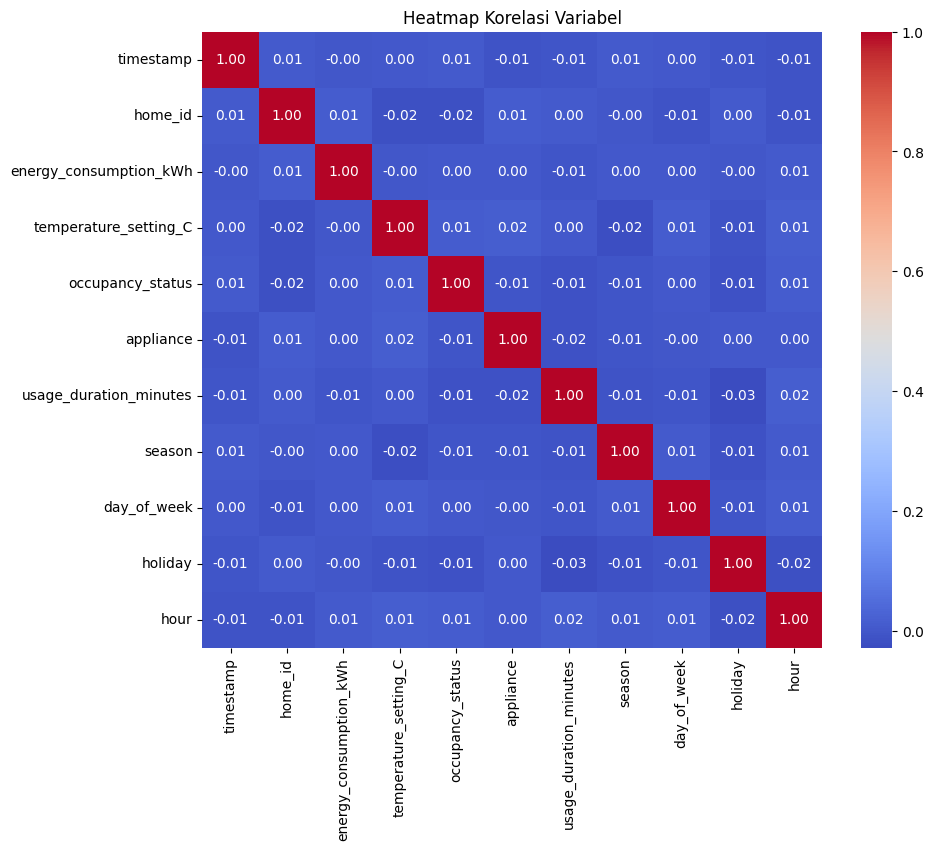

In [11]:

# Heatmap Correlation
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Variabel')
plt.show()


#PCA for Feature Reduction

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.13114877 0.12898417]


In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.13114877 0.12898417]


#MODELLING MENGGUNAKAN LSTM

In [12]:
scaler = MinMaxScaler()
data['scaled_energy'] = scaler.fit_transform(data[[target]])
lstm_data = data[['scaled_energy', 'hour']].values

# Creating sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length, :])
        targets.append(data[i + seq_length, 0])
    return np.array(sequences), np.array(targets)

seq_length = 24
X_lstm, y_lstm = create_sequences(lstm_data, seq_length)

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(seq_length, X_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - loss: 0.1167 - val_loss: 0.0855
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0848 - val_loss: 0.0856
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0849 - val_loss: 0.0866
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0816 - val_loss: 0.0866
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0832 - val_loss: 0.0855
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0824 - val_loss: 0.0859
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0829 - val_loss: 0.0859
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0855 - val_loss: 0.0860
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0822 - val_loss: 0.0875
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0818 - val_loss: 0.0858


# MODELLING MENGGUNAKAN ISOLATION FOREST UNTUK DETEKSI ANOMALI

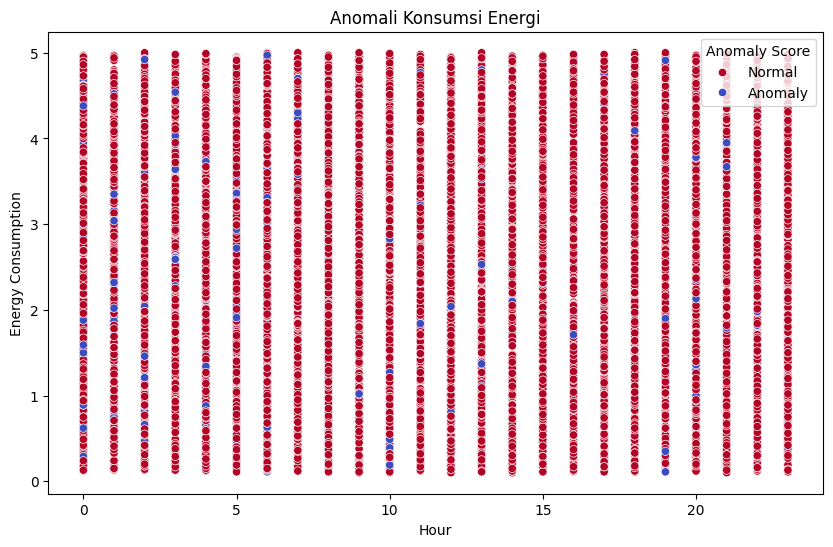

In [28]:


#Model Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_scores = iso_forest.fit_predict(X_pca)  # Hasil prediksi: -1 (anomali) atau 1 (normal)
data['anomaly_score'] = anomaly_scores

#Visualisasi hasil deteksi anomali
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['hour'], y=data[target], hue=data['anomaly_score'], palette='coolwarm')
plt.title('Anomali Konsumsi Energi')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption')
plt.legend(title='Anomaly Score', labels=['Normal', 'Anomaly'])
plt.show()


#MODELLING GENETIK ALGORITHM UNTUK OPTIMIZE
digunakan untuk mengoptimalkan jadwal penggunaan energi di rumah pintar dengan tujuan untuk meminimalkan total konsumsi energi. Secara spesifik, GA digunakan untuk menentukan jadwal penggunaan perangkat berdasarkan durasi penggunaannya, dengan cara berikut:

In [20]:
# Reduce input data size for optimization
X_sample = X.sample(n=1000, random_state=42)
usage_durations = X_sample['usage_duration_minutes'].values

# Define objective function for optimization
def objective_function(schedule):
    schedule = np.round(schedule).astype(int)
    if len(schedule) != len(usage_durations):
        raise ValueError("Schedule length must match the number of samples in the dataset.")
    total_energy = np.sum(schedule * usage_durations)
    return total_energy

# Define bounds and constraints
bounds = [(0, 1)] * len(usage_durations)

# Baseline schedule (contoh: semua perangkat menyala penuh)
baseline_schedule = np.ones(len(usage_durations))  # Jadwal default: semua perangkat aktif
baseline_energy = np.sum(baseline_schedule * usage_durations)

try:
    # Waktu eksekusi GA
    import time
    start_time = time.time()
    result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=100, popsize=15, tol=0.01)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Hasil optimasi
    optimal_schedule = np.round(result.x).astype(int)
    optimized_energy = np.sum(optimal_schedule * usage_durations)

    # Evaluasi
    improvement = (baseline_energy - optimized_energy) / baseline_energy * 100

    # Output evaluasi
    print("Evaluasi Model Genetic Algorithm:")
    print(f"Baseline Total Energy Consumption: {baseline_energy:.2f}")
    print(f"Optimized Total Energy Consumption: {optimized_energy:.2f}")
    print(f"Percentage Improvement: {improvement:.2f}%")
    print(f"Execution Time: {elapsed_time:.2f} seconds")
    print(f"Optimized Schedule: {optimal_schedule}")

except Exception as e:
    print("Error in Genetic Algorithm:", e)

Evaluasi Model Genetic Algorithm:
Baseline Total Energy Consumption: 61262.00
Optimized Total Energy Consumption: 16084.00
Percentage Improvement: 73.75%
Execution Time: 753.86 seconds
Optimized Schedule: [0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1
 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1
 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1
 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 

#RL
Reinforcement Learning (RL) digunakan untuk simulasi otomatisasi rumah pintar terkait konsumsi energi. Secara spesifik, model RL bertujuan untuk mengevaluasi dan mengoptimalkan pengambilan keputusan (action) dalam mengatur sistem rumah pintar berdasarkan kondisi tertentu, dengan tujuan utama meminimalkan konsumsi energi.

In [16]:

# Reinforcement Learning for Smart Automation
class EnergyEnv(gym.Env):
    def __init__(self):
        super(EnergyEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # On/Off
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(features),), dtype=np.float32)
        self.state = np.zeros(len(features))
        self.energy_consumption = 0

    def step(self, action):
        reward = -self.energy_consumption if action == 1 else 0
        self.state = np.random.random(len(features))
        done = False
        return self.state, reward, done, {}

    def reset(self):
        self.state = np.random.random(len(features))
        self.energy_consumption = np.random.random()
        return self.state

# Instantiate and simulate environment
env = EnergyEnv()
state = env.reset()
for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    print(f"State: {state}, Action: {action}, Reward: {reward}")


State: [0.74298909 0.26573579 0.05041769 0.93508147 0.90570752 0.05106685
 0.17815933 0.93639406], Action: 1, Reward: -0.7671191147612167
State: [0.51034636 0.39690518 0.87486826 0.53412839 0.31679807 0.72268077
 0.98709115 0.14168925], Action: 1, Reward: -0.7671191147612167
State: [0.48696879 0.10323676 0.62893401 0.18124652 0.88684281 0.42832375
 0.32803691 0.56976712], Action: 1, Reward: -0.7671191147612167
State: [0.72126702 0.17973939 0.59318202 0.24306811 0.49096609 0.56970032
 0.07561708 0.0353799 ], Action: 0, Reward: 0
State: [0.56926595 0.44591725 0.22722743 0.4185535  0.43099153 0.89584397
 0.64750594 0.13584977], Action: 0, Reward: 0
State: [0.59836297 0.52684196 0.93028605 0.29882687 0.82886216 0.60889263
 0.92988135 0.11942188], Action: 0, Reward: 0
State: [0.77535461 0.28601444 0.26370236 0.40694631 0.90584253 0.16133897
 0.2057015  0.52918402], Action: 1, Reward: -0.7671191147612167
State: [0.22149632 0.50228285 0.30827776 0.53459015 0.11381382 0.13955682
 0.87490119 0.

#EVALUASI MODEL

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM RMSE: 0.29


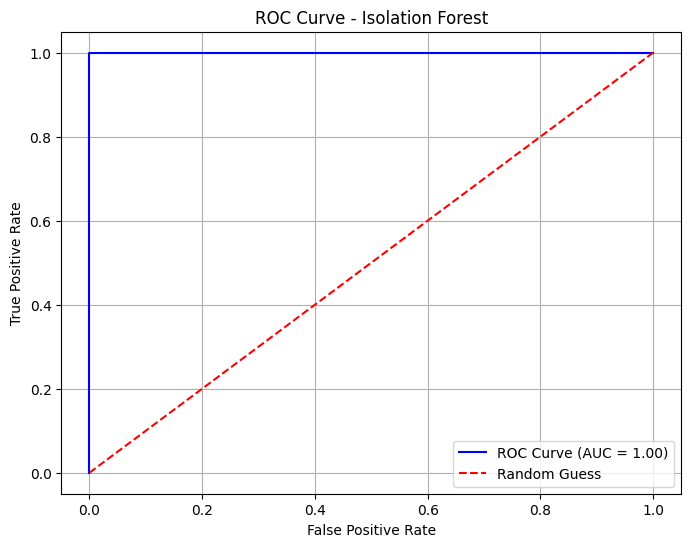

Isolation Forest ROC AUC: 1.00
LSTM RMSE: 0.29


In [29]:
# RMSE for LSTM
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse:.2f}")

# Assign binary labels: 1 (anomali) dan 0 (normal)
labels = (anomaly_scores == -1).astype(int)

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(labels, -iso_forest.decision_function(X_pca))  # Negasi skor untuk ROC
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.title('ROC Curve - Isolation Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Print RMSE and ROC Summary
print(f"Isolation Forest ROC AUC: {roc_auc:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")